In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


dataset = []
import os
import cv2
for dirname, _, filenames in os.walk('/kaggle/input/plant-seedlings-classification/train'):
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename))
        dataset.append(image)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow((dataset[564]))

It seems that not all the images have the same sizes, so we have to resize all the images to a common size. And it seems that there are some noise in the image. So to remove the noise like the measuring tape in the background, the team explored using canny image to remove the lines 


In [ ]:
plt.imshow(cv2.Canny(dataset[564],150,300))

The lines on the background is detected but we cannot find the shape of the leaf itself, so the team wanted to explore if we can segment the image using colour 

In [ ]:
# using colour segmentation to pick out those that are green
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([dataset[2]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()
# the way we interpret this graph is that the x values represent the pixel value and the y value represent how many times the pixel with these values was found in the image



From the colour histogram there isnt a clear threshold where we can split the image, so we have to focus on hue value saturation to segment the image
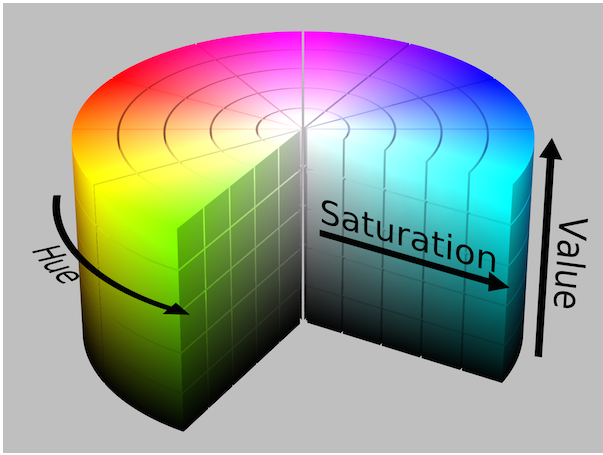


So for light green the value is around (25, 40, 50) and dark green is around (75, 255, 255).

In [ ]:
img_hsv = cv2.cvtColor(dataset[564], cv2.COLOR_BGR2HSV)
# extract the green colour from the hue
lower_mask_hue = img_hsv [:,:,0] >= 25
upper_mask_hue = img_hsv [:,:,0] <= 75
saturation_lower = img_hsv [:,:,1] >= 40
saturation_upper = img_hsv[:,:,1] <= 255
value_lower = img_hsv[:,:,2]>= 50
value_upper  = img_hsv[:,:,2]<=255
mask = lower_mask_hue*upper_mask_hue*saturation_lower*saturation_upper*value_lower*value_upper
red = img_hsv[:,:,0]*mask
green = img_hsv[:,:,1]*mask
blue = img_hsv[:,:,2]*mask
mask = np.dstack((red,green,blue))
plt.imshow(mask);


The image segmentation works but For our KNN algo and Neural network we need to make the data standardise/normalise for the models to be effective so the final function to segment and clean the image is as follows

In [ ]:
def segment_image(image):
    # convert the image to hue 
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # extract the green colour from the hue
    lower_mask_hue = img_hsv [:,:,0] >= 25
    upper_mask_hue = img_hsv [:,:,0] <= 75
    saturation_lower = img_hsv [:,:,1] >= 40
    saturation_upper = img_hsv[:,:,1] <= 255
    value_lower = img_hsv[:,:,2]>= 50
    value_upper  = img_hsv[:,:,2]<=255
    mask = lower_mask_hue*upper_mask_hue*saturation_lower*saturation_upper*value_lower*value_upper
    red = img_hsv[:,:,0]*mask
    green = img_hsv[:,:,1]*mask
    blue = img_hsv[:,:,2]*mask
    mask = np.dstack((red,green,blue))
    mask = cv2.normalize(mask, None, alpha=0,beta =200, norm_type=cv2.NORM_MINMAX)
    return mask